In [209]:
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

# Cohort Analysis

Cohort analysis for a [real online retail store data set](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) (n=525461). *This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011. The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.*

The columns are as follows:

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

In [8]:
# read the raw data
df = pd.read_excel("./data/online_retail_II.xlsx")

In [32]:
df.shape

(525461, 8)

In [31]:
# first few rows of the raw data
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Types of Cohort Analysis

*Cohort analysis* is simply an analysis of different groups of customers/users. Among several types of cohorts (groups), most common types are time-based cohorts, segment-based cohorts, and size-based cohorts.

1. **Time-based cohorts**: grouping customers based on specific time-frames (i.e. time period when customers made an order) to understand their behavior, patterns, and trends more in-depth based on groups.
2. **Segment-based cohorts**: grouping customers by the types of service/product they used/bought. 
3. **Size-based cohorts**: grouping customers by their monetary value.

For this project, let's focus on time-based size cohort analysis.

## Data Cleaning

Before conducting a cohort analysis, let's clean the data. Notice there are quite a lot of rows with missing `Customer ID` value. For the sake of cohort analysis, unique customer id value is required. Thus, let's filter out these rows.

In [40]:
# count the total number of rows with missing Customer ID
duckdb.query("""
    SELECT
        "customer ID",
        COUNT(*) AS total_count
    FROM df
    WHERE "customer ID" IS NULL
    GROUP BY "customer ID"
""").df()

,Customer ID,total_count
0,NaN,107927


In [121]:
# filter out rows with missing customer id
df1 = duckdb.query("""
    SELECT *
    FROM df
    WHERE "customer ID" IS NOT NULL
""").df()

df1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Turns out there are also duplicates in the data. Let's filter these out too.

In [122]:
# select duplicated rows
duckdb.query("""
    SELECT *
    FROM df1
    GROUP BY *
    HAVING COUNT(*) > 1
""").df().head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329.0,United Kingdom
1,489529,22036,DINOSAUR BIRTHDAY CARD,12,2009-12-01 11:51:00,0.42,17984.0,United Kingdom
2,489533,22073,RETRO SPOT STORAGE JAR,1,2009-12-01 12:02:00,3.75,16011.0,United Kingdom
3,489536,21231,SWEETHEART CERAMIC TRINKET BOX,1,2009-12-01 12:13:00,1.25,16393.0,United Kingdom
4,489593,21257,VICTORIAN SEWING BOX MEDIUM,2,2009-12-01 14:19:00,7.95,12836.0,United Kingdom


In [282]:
# filter out duplicated rows using a window function - ROW_NUMBER()
df2 = duckdb.query("""
    SELECT *
    FROM
    (
        SELECT *,
            ROW_NUMBER() OVER(PARTITION BY Invoice, StockCode, Description, Quantity, InvoiceDate, Price, "Customer ID", Country) AS row_num
        FROM df1
    ) AS t1
    WHERE row_num = 1
""").df()

df2.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,row_num
0,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1
1,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,1
2,489436,21333,CLASSIC WHITE FRAME,6,2009-12-01 09:06:00,2.95,13078.0,United Kingdom,1
3,489436,21755,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.45,13078.0,United Kingdom,1
4,489436,22111,SCOTTIE DOG HOT WATER BOTTLE,24,2009-12-01 09:06:00,4.25,13078.0,United Kingdom,1


Few rows contain negative values for quantity and Price. Let's filter those rows out as well for the sake of cohort analysis.

In [127]:
duckdb.query("""
    SELECT *
    FROM df2
    WHERE
        Quantity < 0 OR
        Price < 0
""").df().head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,row_num
0,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.0,Australia,1
1,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,1
2,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,1
3,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.0,Australia,1
4,C489459,90003D,CRYSTAL PAIR HEART HAIR SLIDES,-3,2009-12-01 10:44:00,3.75,17592.0,United Kingdom,1


In [130]:
df3 = duckdb.query("""
    SELECT *
    FROM df2
    WHERE
        Quantity > 0 AND
        Price > 0
""").df()

In [131]:
df3.shape

(400916, 9)

## Cohort Analysis with SQL and Python

In [181]:
# create a function which returns data in pandas data frame format
# with the given query
def q(query):
    return duckdb.query(query).df()

First, to conduct a cohort analysis, we need three main values: payment period, cohort, and cohort index.

In [200]:
# 1. a new column: truncate datetime to month
# 2. a new column: specify each customer's cohort
# 3. group by these newly created columns and count the unique number of customers
# 4. a new column: period_num indicates the gap between cohort and month of order
cohorts = q("""
    WITH cohorts AS
    (
        SELECT *,
            DATE_TRUNC('Month', InvoiceDate) AS order_month,
            MIN(order_month) OVER(PARTITION BY "Customer ID") as cohort
        FROM df3
        ORDER BY InvoiceDate
    )
    
    SELECT
        cohort,
        order_month,
        COUNT(DISTINCT "Customer ID") AS n_customers,
        DATE_DIFF('Month', cohort, order_month) AS period_num
    FROM cohorts
    GROUP BY cohort, order_month
    ORDER BY cohort, order_month
""")

cohorts

,cohort,order_month,n_customers,period_num
0,2009-12-01,2009-12-01,955,0
1,2009-12-01,2010-01-01,337,1
2,2009-12-01,2010-02-01,319,2
3,2009-12-01,2010-03-01,406,3
4,2009-12-01,2010-04-01,363,4
...,...,...,...,...
86,2010-10-01,2010-11-01,97,1
87,2010-10-01,2010-12-01,35,2
88,2010-11-01,2010-11-01,325,0
89,2010-11-01,2010-12-01,35,1


To calculate retention rates, divide each month by the total size of the corresponding cohort. 

In [241]:
# compute the cohort size using window function, 
# then divide each month's number of customers by its size
retention = q("""
    SELECT
        STRFTIME(cohort, '%Y-%m') AS cohort,
        period_num,
        MAX(n_customers) OVER(PARTITION BY cohort) AS size,
        ROUND(n_customers / size::DECIMAL, 2) AS retention
    FROM cohorts
""")

retention.head(5)

,cohort,period_num,size,retention
0,2009-12,0,955,1.00
1,2009-12,1,955,0.35
2,2009-12,2,955,0.33
3,2009-12,3,955,0.43
4,2009-12,4,955,0.38


In [272]:
# convert the retention table to see more clearly
retention_pivoted = retention.pivot_table(index='cohort', columns="period_num", values="retention")
retention_pivoted

period_num,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2009-12,1.0,0.35,0.33,0.43,0.38,0.36,0.38,0.34,0.34,0.36,0.42,0.5,0.25
2010-01,1.0,0.21,0.31,0.31,0.26,0.30,0.26,0.23,0.28,0.32,0.30,0.1,NaN
2010-02,1.0,0.24,0.22,0.29,0.25,0.20,0.19,0.29,0.25,0.28,0.07,NaN,NaN
2010-03,1.0,0.19,0.23,0.24,0.23,0.20,0.25,0.30,0.28,0.08,NaN,NaN,NaN
2010-04,1.0,0.19,0.19,0.16,0.18,0.22,0.28,0.26,0.07,NaN,NaN,NaN,NaN
2010-05,1.0,0.16,0.17,0.17,0.18,0.26,0.21,0.08,NaN,NaN,NaN,NaN,NaN
2010-06,1.0,0.17,0.19,0.20,0.23,0.29,0.07,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.16,0.18,0.30,0.29,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.20,0.30,0.32,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's create a visualization using seaborn.

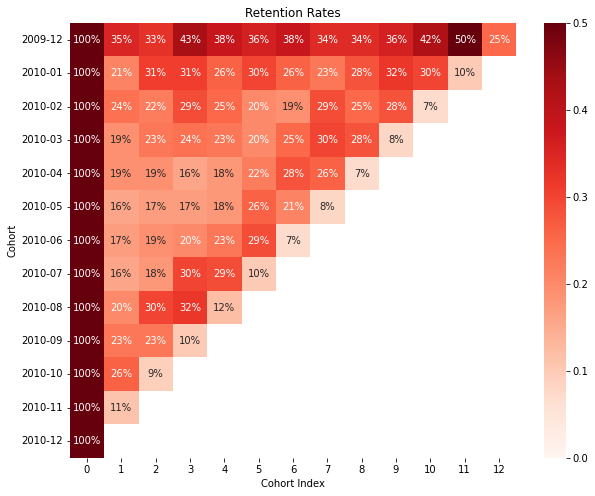

In [273]:
# create a new figure
fig, ax = plt.subplots(figsize=(10,8))

# create a heatmap indicating retention rate
sns.heatmap(data=retention_pivoted, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='Reds')

# set labels
ax.set(title="Retention Rates", xlabel="Cohort Index", ylabel="Cohort")

plt.show()

The first column (Cohort index of 0) will always be 100% since it divides by itself (the size of each cohort). Notice the first cohort (2009-12) has high retention (~30-40%) rate compared to that of other cohorts and there's a peak at the 11th month (50%) which potentially indicates the seasonal shopping crowd. 

### Cohort Analysis - Quantity

In [283]:
# create cohorts and calculate the average quanity of all purchases per cohort
quantity = q("""
    WITH cohorts AS
    (
        SELECT *,
            DATE_TRUNC('Month', InvoiceDate) AS order_month,
            MIN(order_month) OVER(PARTITION BY "Customer ID") as cohort
        FROM df3
        ORDER BY InvoiceDate
    )
    
    SELECT
        STRFTIME(cohort, '%Y-%m') AS cohort,
        order_month,
        ROUND(AVG(Quantity), 1) AS avg_quan,
        DATE_DIFF('Month', cohort, order_month) AS period_num
    FROM cohorts
    GROUP BY cohort, order_month
    ORDER BY cohort, order_month
""")

quantity.head(5)

,cohort,order_month,avg_quan,period_num
0,2009-12,2009-12-01,13.2,0
1,2009-12,2010-01-01,23.4,1
2,2009-12,2010-02-01,21.6,2
3,2009-12,2010-03-01,22.6,3
4,2009-12,2010-04-01,13.6,4


In [284]:
# convert the retention table to see more clearly
quantity_pivoted = quantity.pivot_table(index='cohort', columns="period_num", values="avg_quan")
quantity_pivoted

period_num,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2009-12,13.2,23.4,21.6,22.6,13.6,15.3,14.3,14.4,26.5,17.6,16.1,14.2,13.1
2010-01,9.6,14.2,9.7,13.3,13.1,13.3,12.2,12.8,12.4,13.0,11.0,11.6,NaN
2010-02,10.1,10.1,16.1,13.2,10.3,12.2,12.3,10.7,9.6,10.2,10.4,NaN,NaN
2010-03,10.4,13.8,11.9,13.4,11.0,13.7,13.2,11.7,11.9,19.1,NaN,NaN,NaN
2010-04,10.7,9.0,10.5,14.6,12.6,10.4,10.4,9.9,7.6,NaN,NaN,NaN,NaN
2010-05,12.2,9.4,10.3,12.5,13.1,9.4,7.6,5.5,NaN,NaN,NaN,NaN,NaN
2010-06,10.9,8.9,13.6,10.8,11.5,14.2,13.2,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,8.5,8.9,7.3,8.9,7.4,6.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,8.3,8.8,8.9,7.6,12.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


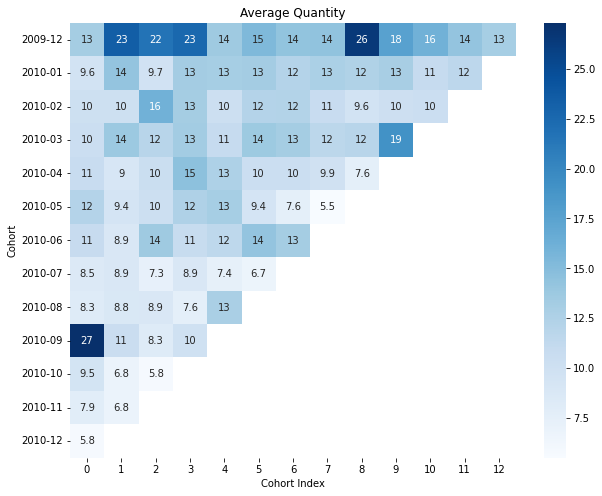

In [287]:
# create a new figure
fig, ax = plt.subplots(figsize=(10,8))

# create a heatmap indicating retention rate
sns.heatmap(data=quantity_pivoted, annot=True, cmap='Blues')

# set labels
ax.set(title="Average Quantity", xlabel="Cohort Index", ylabel="Cohort")

plt.show()

We can observe a couple of outliers in the heatmap above. This is possibily due to marketing campaigns such as sale, clearance, etc. Fortunately, customers keep buying ceratin amount of products. Notice first 5 cohorts. Once they make a payment, they also buy certain quantities in subsequent months, except for cohort 2010-09. The irregular peak of 27 might be due to a one-time marketing campaign and it turns out that campaign was not successful.

### Cohort Analysis - Price

What are the average prices of products purchased per cohort in subsequent months?

In [291]:
# create cohorts and calculate the average quanity of all purchases per cohort
price = q("""
    WITH cohorts AS
    (
        SELECT *,
            DATE_TRUNC('Month', InvoiceDate) AS order_month,
            MIN(order_month) OVER(PARTITION BY "Customer ID") as cohort
        FROM df3
        ORDER BY InvoiceDate
    )
    
    SELECT
        STRFTIME(cohort, '%Y-%m') AS cohort,
        order_month,
        ROUND(AVG(Price), 1) AS avg_price,
        DATE_DIFF('Month', cohort, order_month) AS period_num
    FROM cohorts
    GROUP BY cohort, order_month
    ORDER BY cohort, order_month
""")

price.head(5)

,cohort,order_month,avg_price,period_num
0,2009-12,2009-12-01,3.2,0
1,2009-12,2010-01-01,4.5,1
2,2009-12,2010-02-01,3.1,2
3,2009-12,2010-03-01,3.2,3
4,2009-12,2010-04-01,3.1,4


In [293]:
# convert the retention table to see more clearly
price_pivoted = price.pivot_table(index='cohort', columns="period_num", values="avg_price")
price_pivoted

period_num,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2009-12,3.2,4.5,3.1,3.2,3.1,3.2,3.1,3.1,3.3,3.9,3.5,3.0,3.1
2010-01,3.2,2.9,3.2,3.0,3.2,3.5,3.5,3.1,3.6,3.1,3.2,3.3,NaN
2010-02,3.3,3.1,4.1,3.1,3.2,3.3,3.7,2.8,2.8,3.1,3.1,NaN,NaN
2010-03,5.0,3.1,3.0,2.9,3.0,2.7,2.6,2.9,3.1,3.1,NaN,NaN,NaN
2010-04,3.3,3.7,3.4,3.8,3.0,2.8,3.1,3.2,4.0,NaN,NaN,NaN,NaN
2010-05,3.3,3.5,2.9,2.7,3.0,2.7,3.0,3.1,NaN,NaN,NaN,NaN,NaN
2010-06,3.5,3.2,2.8,3.0,3.0,3.0,3.2,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,4.1,3.2,2.6,3.0,3.1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,3.1,3.3,3.2,3.1,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


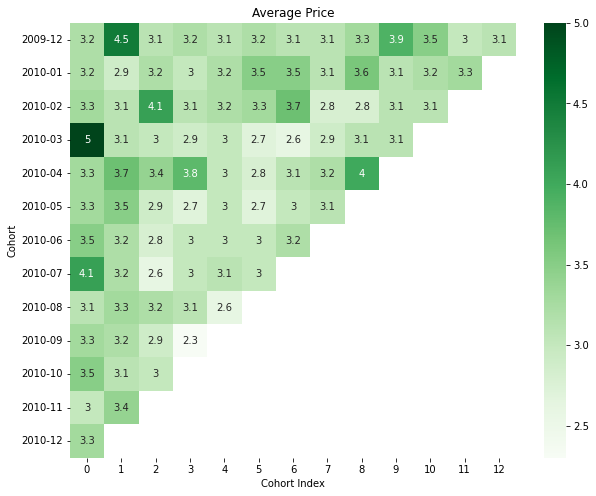

In [297]:
# create a new figure
fig, ax = plt.subplots(figsize=(10,8))

# create a heatmap indicating retention rate
sns.heatmap(data=price_pivoted, annot=True, cmap='Greens')

# set labels
ax.set(title="Average Price", xlabel="Cohort Index", ylabel="Cohort")

plt.show()

There are several cohort index for certain cohorts where the average price of purchased items are particularly higher than that of others. We defintely would like to know what advertisement / marketing campaign was proceeded at that time period so that we can invest more in those.

### References

- [A Complete Guide to Revenue Cohort Analysis in SQL and Python](https://towardsdatascience.com/a-complete-guide-to-revenue-cohort-analysis-in-sql-and-python-9eeecd4c731a)
- [Cohort Analysis with Python](https://www.kaggle.com/code/ahmetokanyilmaz/cohort-analysis-with-python)
- [Understanding Customer Retention Rates with Cohort Analysis using Python and Seaborn](https://yuanyexi.medium.com/understanding-customer-retention-rates-with-cohort-analysis-using-python-and-seaborn-5da6ea015935)